<a href="https://colab.research.google.com/github/voquangtuong/DL_Tutorial/blob/master/LSTM_multi_input_multi_out_Jacson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code from the book page 412
Predict the feature with MLP CNN and LSTM in python

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import sqrt
#
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as KK
from matplotlib.gridspec import GridSpec

# BASIC FUNCTIONS

## split data function

In [3]:
def split_dataset(data,train_test_ratio,n_output_steps):
  # split into standard weeks
  # boi so cua buoc
  n_pairs_totall=int(data.shape[0]/n_output_steps)
  n_pairs_train=int(train_test_ratio*int(data.shape[0]/n_output_steps))
  n_pairs_test=int(n_pairs_totall-n_pairs_train)
  train, test = data[:-(n_pairs_train*n_output_steps)], data[-(n_pairs_train*n_output_steps):-n_output_steps]
  # restructure into windows of number_steps data
  train = np.array(np.split(train, train.shape[0]/n_output_steps))
  test = np.array(np.split(test, test.shape[0]/n_output_steps))
  return train, test

## Evaluate forecasts function

In [4]:
def evaluate_forecasts(actual,predicted):
  scores=list()
  for i in range(actual.shape[1]):
    mse=mean_squared_error(actual[:,i],predicted[:,i])
    rmse=sqrt(mse)
    scores.append(rmse)
  # calculate overall RMSE
  s=0
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s+=(actual[row,col]-predicted[row,col])**2
  score=sqrt(s/(actual.shape[0]*actual.shape[1]))
  return score, scores
  # score: sai so trung binh toan bo
  # scores: sai so cua tung buoc

## Summarize scores function

In [5]:
# summarize scores
def summarize_scores(name, score, scores):
  s_scores=','.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s' %(name, score,s_scores))

## Timeseries to suppervised function

In [6]:
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=6):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    # ensure we have enough data for this instance
    if out_end < len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
  # move along one time step
  in_start += 1
  return np.array(X), np.array(y)

## Train LSTM model function

In [7]:
# train the model
def build_model(train, n_input):
  # prepare data
  train_x, train_y = to_supervised(train, n_input)
  # define parameters
  verbose, epochs, batch_size = 0, 500, 16
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  # reshape output into [samples, timesteps, features]
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  KK.clear_session()
  # define model
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(200, activation='relu', return_sequences=True))
  model.add(LSTM(200, activation='relu', return_sequences=True))  
  model.add(TimeDistributed(Dense(100, activation='relu')))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss='mse', optimizer='adam')
  model.summary()
  # fit network
  model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
  plot_model(model,to_file='model_plot_lstm.png',show_shapes=True,show_layer_names=True)
  return model

## Make a forecast function

In [8]:
# make a forecast
def forecast(model, history, n_input):
  # flatten data
  data = np.array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, :] # lay het cac bien dau vao
  # reshape into [1, n_input, n]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat


## evaluate model function

In [9]:
# evaluate a single model
def evaluate_model(train, test, n_input):
# fit model
  model = build_model(train, n_input)
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, n_input)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = np.array(predictions)
  score, scores = evaluate_forecasts(test[:, :, 0], predictions)
  return score, scores, test, predictions

# LOAD DATA

In [10]:
# load the new file
dataset = pd.read_csv('input_data/percentile_101.csv', header=0,
infer_datetime_format=True, parse_dates=['Date'], index_col=['Date'])
# split into train and test
train, test = split_dataset(dataset.values,train_test_ratio=0.23,n_output_steps=6) # thay 7 ngay thanh 6 thang

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               376000    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 6, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 200)            320800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 200)            320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 6, 100)            20100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 1)              101       
Total params: 1,037,801
Trainable params: 1,037,801
Non-trainable params: 0
______________________________________________

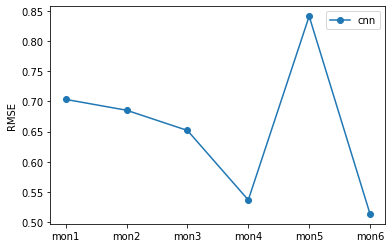

In [11]:
n_input = 12 # 24 thang tot nhat cho cnn
score, scores, test, predictions = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['mon1', 'mon2', 'mon3', 'mon4', 'mon5', 'mon6']
plt.plot(days, scores, marker='o', label='cnn')
plt.legend()
plt.ylabel('RMSE')
plt.show()

# FURTHER FARMING

In [12]:
test.shape

(15, 6, 269)

In [13]:
test[:,:,0].shape

(15, 6)

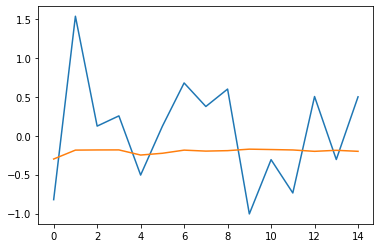

In [14]:
plt.plot(test[:,:,0][:,0])
plt.plot(predictions[:,:,0][:,0])


In [15]:
predictions.shape

(15, 6, 1)

In [16]:
predictions[:,:,0][:,0]

array([-0.29960188, -0.18520208, -0.18314506, -0.18252447, -0.24857898,
       -0.22585213, -0.18543048, -0.19798164, -0.19211371, -0.17295809,
       -0.17782691, -0.18326466, -0.20091791, -0.18778005, -0.20073943],
      dtype=float32)

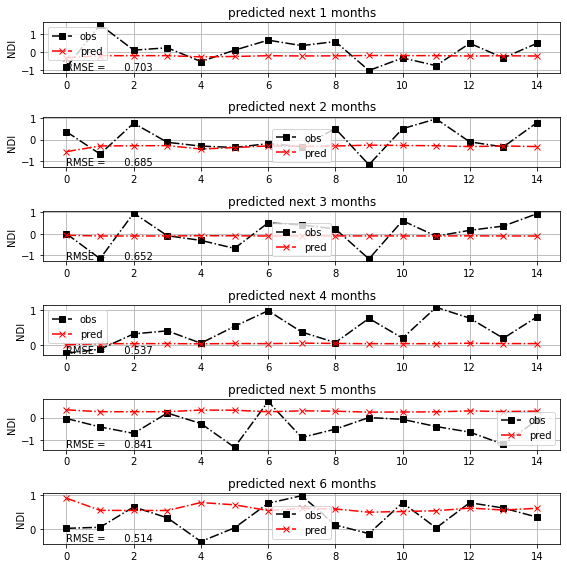

In [17]:
fig = plt.figure(figsize=(8, 8))
# plt.subplots(3,1,sharex=True)
gs = GridSpec(nrows=6, ncols=1)
for j in range(6):
  ax = fig.add_subplot(gs[j, 0])
  ax=plt.plot(test[:,:,0][:,j],'-.s',color='black') #'-.s'
  ax=plt.plot(predictions[:,:,0][:,j],'-.x',color='red') #'-.ro'
  ax=plt.text(0,test[:,:,0][:,j].min(),'RMSE = '+'%10.3f' %scores[j])
#   ax=plt.text(0,np.array(actual)[:,j].min(),'RMSE = '+ '{:10.3f}'.format(rmse_all[j]))  
  # ax=plt.text(0,np.array(actual)[:,j].min(),'RMSE = '+ '%10.3f' %rmse_all[j])  
  # plt.title('predicted the '+ month_names[j]+' of next year')
  plt.title('predicted next '+str(j+1)+' months')
  plt.grid(None)
  # plt.xlabel('months')
  plt.ylabel('NDI')
  plt.legend(['obs','pred'])
  
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

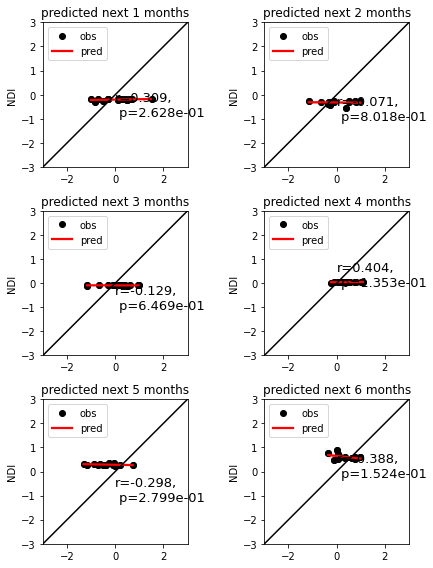

In [18]:
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8, 8))
# plt.subplots(3,1,sharex=True)
gs = GridSpec(nrows=int(6/2), ncols=2)
jjj=0
for j in range(int(6/2)):
  for jj in range(2):
    jjj+=1
    corr = pearsonr(test[:,:,0][:,jjj-1], predictions[:,:,0][:,jjj-1])
    # corr = [np.round(c, 2) for c in corr]
    #add the coefficient to your graph
    text = 'r=%4.3f,\n p=%4.3e' % (corr[0], corr[1])    
    ax = fig.add_subplot(gs[j, jj])
    ax=plt.plot(test[:,:,0][:,jjj-1],predictions[:,:,0][:,jjj-1],'o',color='black')
    ax=sns.regplot(test[:,:,0][:,jjj-1],predictions[:,:,0][:,jjj-1],scatter_kws={"color": "black"}, line_kws={"color": "red"})
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    # plt.title("Compare prediction and observation")
    plt.text(0,test[:,:,0][:,jjj-1].min()+0.1, text, fontsize=13)
    # plt.title('predicted the '+ month_names[j]+' of next year')
    plt.title('predicted next '+str(jjj)+' months')
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    plt.grid(False)
    
    # plt.xlabel('months')
    plt.ylabel('NDI')
    plt.legend(['obs','pred'])
    
    # plt.axis('equal')
    # plt.axis('square')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.draw()
    plt.tight_layout()
plt.tight_layout()   